In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import glob

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = 'C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'



# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [8]:
class EClassConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'
    
    USE_MINI_MASK = False

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32,64,128,256,512)
    LEARNING_RATE = 0.0001
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = EClassConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [9]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [10]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant/dataset/custom/train.json', 'C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant/dataset/custom/train')
dataset_train.prepare()


dataset_val = CocoLikeDataset()
dataset_val.load_data('C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant/dataset/custom/val.json', 'C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant/dataset/custom/val')
dataset_val.prepare()

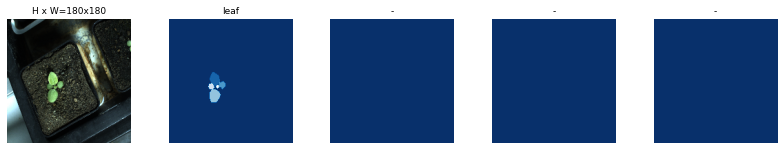

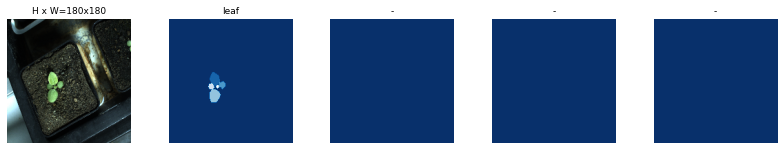

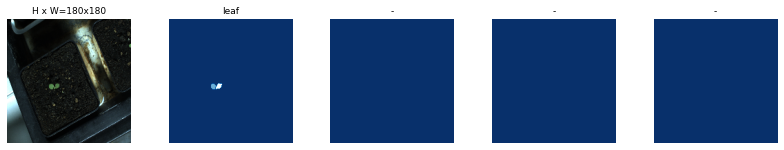

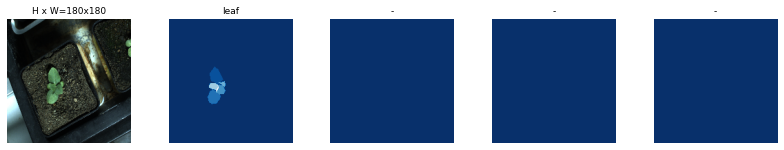

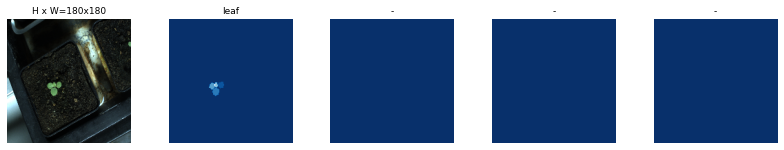

In [12]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=25, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.0001

Checkpoint Path: C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant\logs\custom20201028T1417\mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4  

C:\Users\ISYSRG.COM\Anaconda3\envs\mask-rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - 109s 219ms/step - loss: 0.6151 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.1956 - val_loss: 0.3952 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.2004 - val_mrcnn_class_loss: 0.0295 - val_mrcnn_bbox_loss: 0.0319 - val_mrcnn_mask_loss: 0.1251
Epoch 2/25
500/500 [==============================] - 88s 176ms/step - loss: 0.2662 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.1356 - val_loss: 0.1820 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.0190 - val_mrcnn_class_loss: 0.0244 - val_mrcnn_bbox_loss: 0.0079 - val_mrcnn_mask_loss: 0.1272
Epoch 3/25
500/500 [==============================] - 89s 178ms/step - loss: 0.2015 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.1148 - val_loss: 0.1446 - val_rpn_class_loss:

500/500 [==============================] - 99s 199ms/step - loss: 0.0671 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 6.6248e-04 - mrcnn_mask_loss: 0.0549 - val_loss: 0.0623 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 1.5586e-04 - val_mrcnn_class_loss: 0.0034 - val_mrcnn_bbox_loss: 5.7052e-04 - val_mrcnn_mask_loss: 0.0529pn_bbox_loss: 0.0036 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 7.3478e-04 - mrcnn_mask_loss:  - ETA: 1:22 - loss: 0.0623 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0038 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 6.8642e-04 - mrcnn_mask_lo - ETA: 1:20 - loss: 0.0658 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0047 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss:  - ETA: 1:14 - loss: 0.0656 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0044 - mrcnn_ - ETA: 1:00 - loss: 0.0682 - rpn_class_loss: 9.1517e-04 - rpn_bbox_loss: 0.0053 - mrcnn_class_loss: 0.006 - ETA: 39s - loss: 0.0670 - rpn_class_loss: 9.5090e-04 - rpn

In [16]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=50, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 25. LR=0.0001

Checkpoint Path: C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant\logs\custom20201028T1417\mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

C:\Users\ISYSRG.COM\Anaconda3\envs\mask-rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - 159s 317ms/step - loss: 0.2682 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0130 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0717 - val_loss: 0.2165 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.0140 - val_mrcnn_class_loss: 0.0111 - val_mrcnn_bbox_loss: 0.0125 - val_mrcnn_mask_loss: 0.0679
Epoch 27/50
500/500 [==============================] - 151s 302ms/step - loss: 0.2190 - rpn_class_loss: 7.0724e-04 - rpn_bbox_loss: 0.0067 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.0666 - val_loss: 0.2078 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.0014 - val_mrcnn_class_loss: 0.0269 - val_mrcnn_bbox_loss: 0.0044 - val_mrcnn_mask_loss: 0.0659
Epoch 28/50
500/500 [==============================] - 150s 299ms/step - loss: 0.2096 - rpn_class_loss: 7.4871e-04 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.0663 - val_loss: 0.1449 - val_rpn

Epoch 47/50
500/500 [==============================] - 198s 396ms/step - loss: 0.1250 - rpn_class_loss: 2.6714e-04 - rpn_bbox_loss: 4.3438e-04 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.0488 - val_loss: 0.1127 - val_rpn_class_loss: 5.4428e-04 - val_rpn_bbox_loss: 1.5740e-04 - val_mrcnn_class_loss: 0.0018 - val_mrcnn_bbox_loss: 0.0017 - val_mrcnn_mask_loss: 0.0521
Epoch 48/50
500/500 [==============================] - 201s 403ms/step - loss: 0.1394 - rpn_class_loss: 2.6249e-04 - rpn_bbox_loss: 7.5737e-04 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.0497 - val_loss: 0.1063 - val_rpn_class_loss: 8.7260e-05 - val_rpn_bbox_loss: 3.4219e-04 - val_mrcnn_class_loss: 0.0021 - val_mrcnn_bbox_loss: 0.0033 - val_mrcnn_mask_loss: 0.0473
Epoch 49/50
500/500 [==============================] - 202s 403ms/step - loss: 0.1346 - rpn_class_loss: 2.6835e-04 - rpn_bbox_loss: 6.1212e-04 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0030 - mrcnn_ma

In [17]:
class InferenceConfig(EClassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    USE_MINI_MASK = False
    
    
inference_config = InferenceConfig()

In [18]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [19]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant\logs\custom20201028T1417\mask_rcnn_custom_0050.h5
Re-starting from epoch 50


Processing 1 images
image                    shape: (180, 180, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


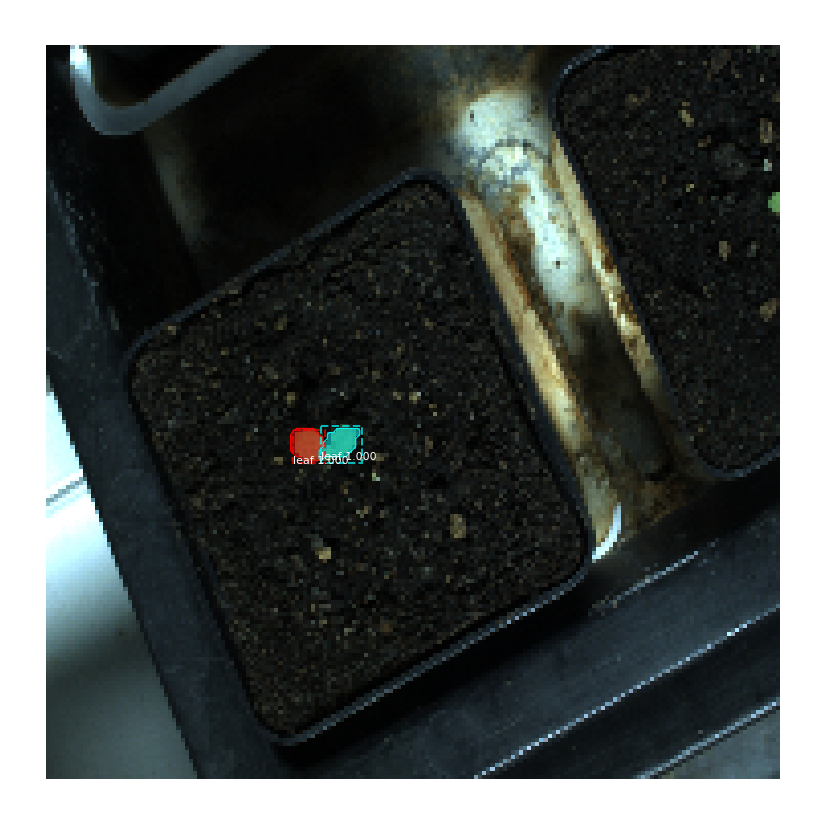

Processing 1 images
image                    shape: (180, 180, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


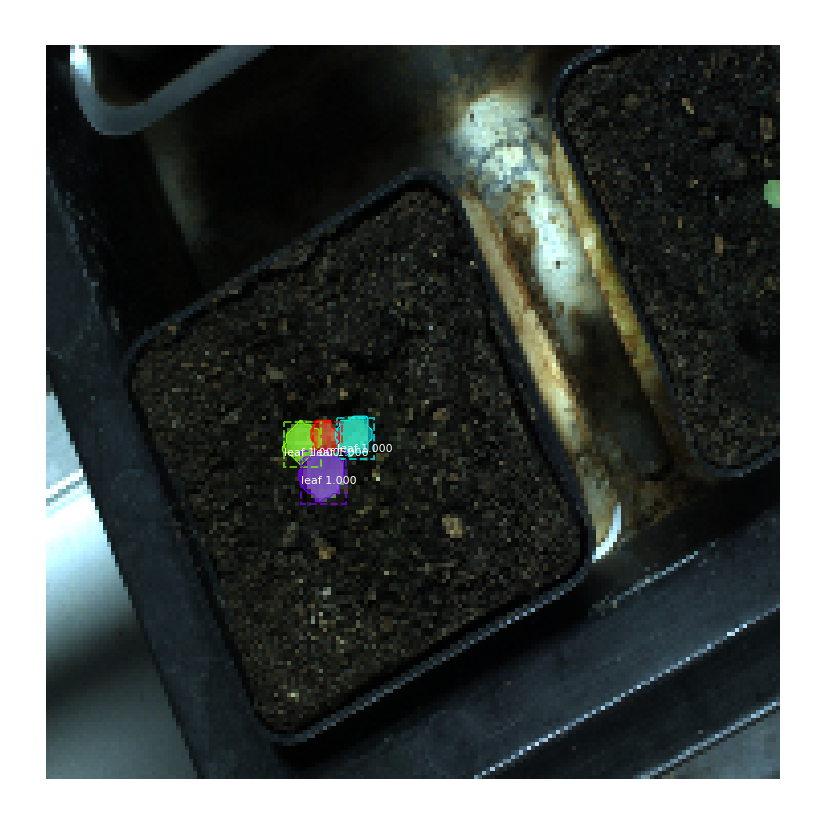

Processing 1 images
image                    shape: (180, 180, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


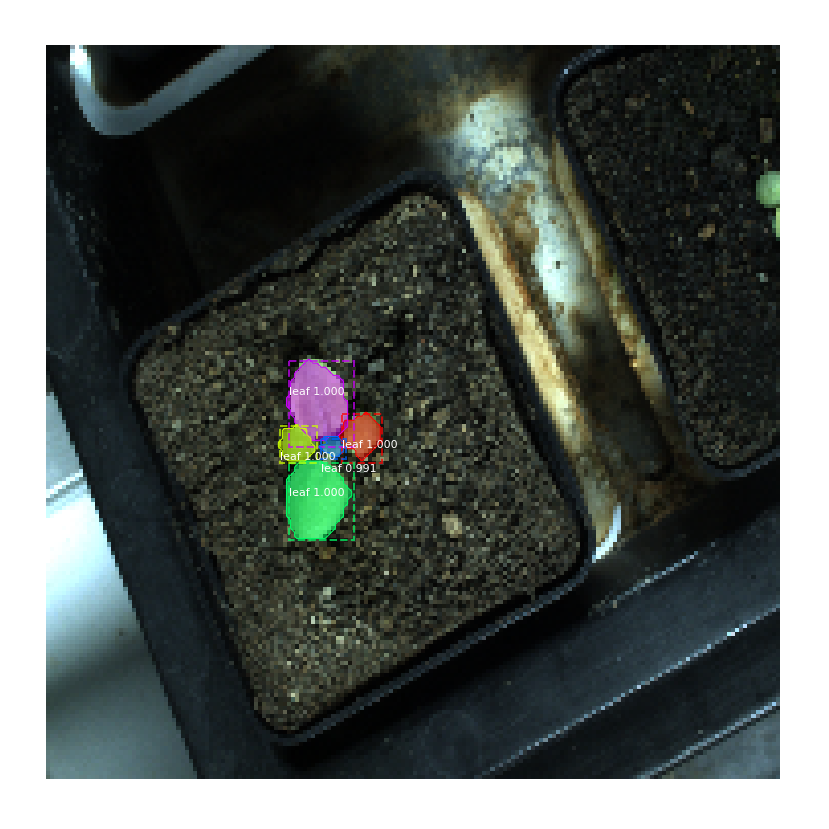

Processing 1 images
image                    shape: (180, 180, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


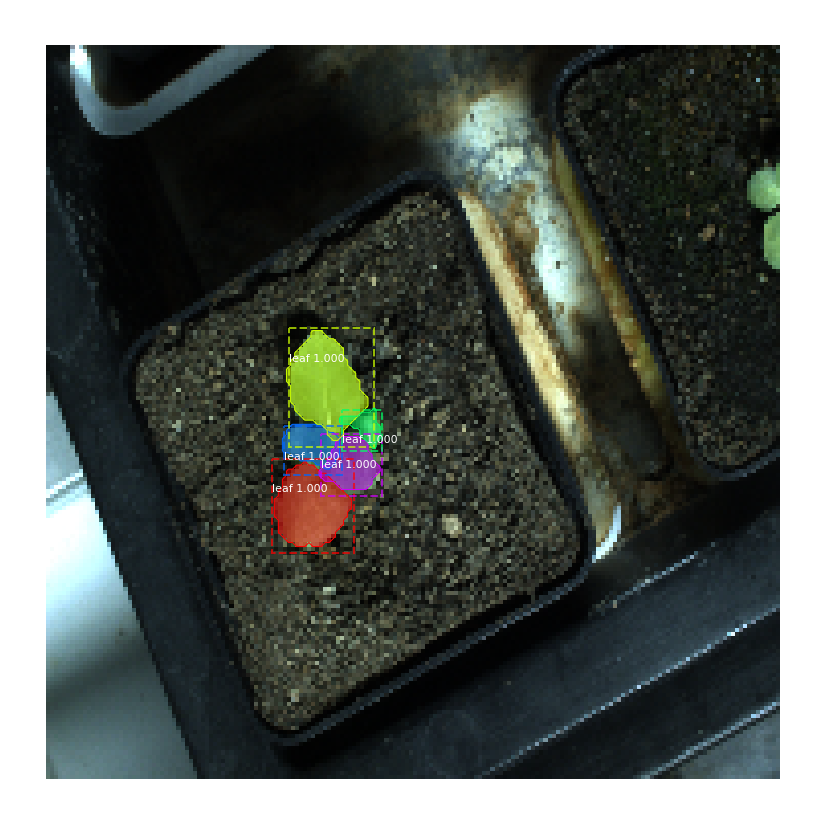

Processing 1 images
image                    shape: (180, 180, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


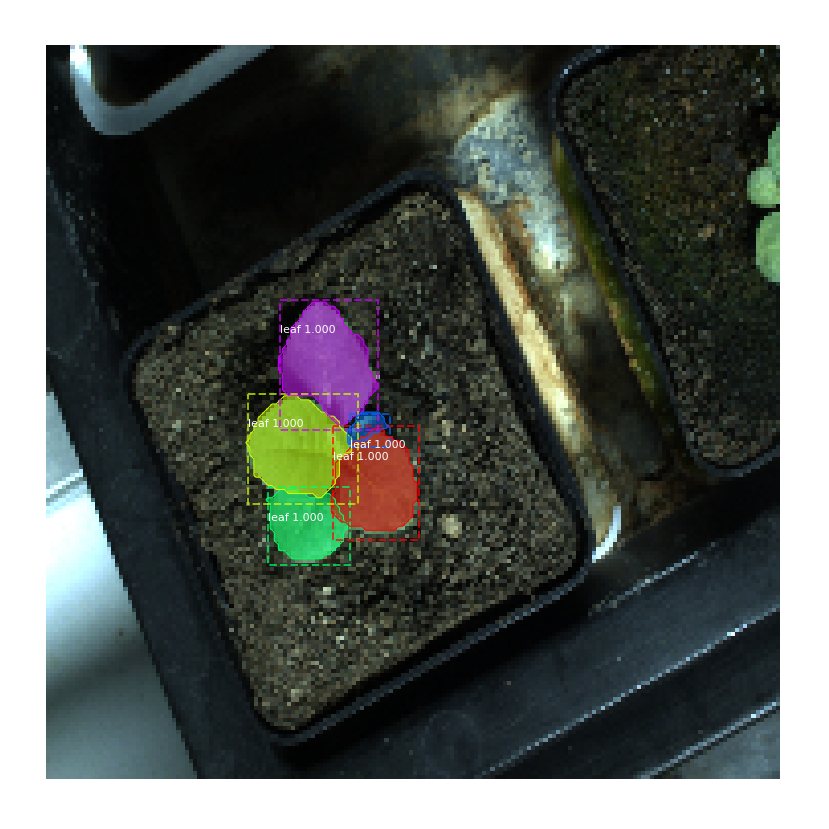

In [20]:
import skimage
real_test_dir = 'C:/Users/ISYSRG.COM/Documents/JO Gans/mask-rcnn-plant/dataset/custom/test'

image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
 
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(15,15))